# XGBoost

XGBoost will create decision trees to determine a features weight then adjust weight based on each previous models error. Each predictor is trained using the residual errors of predecessor as labels. 

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import accuracy_score, precision_score, recall_score, log_loss
from sklearn.model_selection import RandomizedSearchCV
from sklearn import tree
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings("ignore") 

In [2]:
df = pd.read_csv('df_dummies.csv')

In [3]:
df= df.drop(columns=['Unnamed: 0'], axis=1)

In [4]:
X = df.drop(columns=['DepDelay'], axis=1)
y= df['DepDelay']

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [6]:
scaler = StandardScaler()
scaler.fit(X_train)

StandardScaler()

In [7]:
scaler_X_train = scaler.transform(X_train)
scaler_X_test = scaler.transform(X_test)

#### Baseline XGB 

In [8]:
xgbc = XGBClassifier(eval_metric='logloss')
xgbc = xgbc

In [9]:
xgbc.fit(scaler_X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='logloss',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=4,
              num_parallel_tree=1, random_state=0, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=1, tree_method='exact',
              validate_parameters=1, verbosity=None)

In [10]:
df_col = list(df.columns)
df_col.remove('DepDelay')

In [11]:
df_feat = pd.DataFrame(xgbc.feature_importances_, index=df_col, columns=['feature importance']).sort_values('feature importance', ascending=False)
df_feat

,feature importance
Dest_ORD,0.256904
ArrTime,0.126804
Dest_DEN,0.108092
Dest_LAX,0.089302
Distance,0.080668
Dest_DFW,0.080572
Month,0.072735
DayofMonth,0.064105
DayofWeek,0.062530
Dest_ATL,0.058288


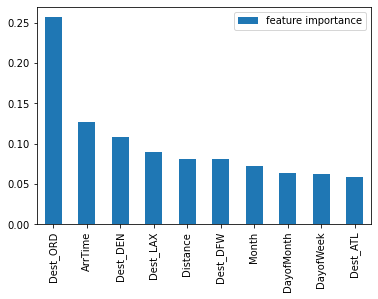

In [12]:
df_feat.plot(kind='bar');

##### Model Train

In [13]:
xgbc_pred_train = xgbc.predict(scaler_X_train)

In [14]:
print(classification_report(y_train, xgbc_pred_train, target_names=['On Time', 'Delay']))

              precision    recall  f1-score   support

     On Time       0.72      0.21      0.32     41471
       Delay       0.71      0.96      0.82     84542

    accuracy                           0.71    126013
   macro avg       0.71      0.58      0.57    126013
weighted avg       0.71      0.71      0.65    126013



In [15]:
print('Mean Absolute Error:', mean_absolute_error(y_train, xgbc_pred_train))
print('Mean Squared Error:', mean_squared_error(y_train, xgbc_pred_train))  
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_train, xgbc_pred_train)))

Mean Absolute Error: 0.28817661669827715
Mean Squared Error: 0.28817661669827715
Root Mean Squared Error: 0.5368208422726125


##### Model Test

In [16]:
xgbc_pred_test = xgbc.predict(scaler_X_test)

In [17]:
print(classification_report(y_test, xgbc_pred_test, target_names=['On Time', 'Delay']))

              precision    recall  f1-score   support

     On Time       0.58      0.16      0.25     13695
       Delay       0.70      0.94      0.80     28310

    accuracy                           0.69     42005
   macro avg       0.64      0.55      0.53     42005
weighted avg       0.66      0.69      0.62     42005



In [18]:
print('Mean Absolute Error:', mean_absolute_error(y_test, xgbc_pred_test))
print('Mean Squared Error:', mean_squared_error(y_test, xgbc_pred_test))  
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test, xgbc_pred_test)))

Mean Absolute Error: 0.31234376859897633
Mean Squared Error: 0.31234376859897633
Root Mean Squared Error: 0.5588772392922943


##### Confusion Matrix

In [19]:
base_cnf_matrix = confusion_matrix(y_test, xgbc_pred_test)
base_cnf_matrix

array([[ 2196, 11499],
       [ 1621, 26689]], dtype=int64)

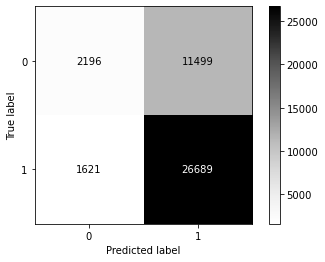

In [20]:
plot_confusion_matrix(xgbc, scaler_X_test, y_test,
                      cmap=plt.cm.Greys)
plt.show()

#### Random Search

In [21]:
xgb_param_grid={
    'learning_rate': [0.1, 0.2, 0.3, 0.4],
    'gamma': [0, 1, 2, 3],
    'max_depth': [20,60],
    'min_child_weight': [1, 2],
    'subsample': [0.2, 0.5, 0.7, 0.9],
}

In [22]:
xgb_rand_search = RandomizedSearchCV(xgbc, xgb_param_grid)

##### Model Train

In [23]:
xgb_rand_search.fit(scaler_X_train, y_train)

RandomizedSearchCV(estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                           colsample_bylevel=1,
                                           colsample_bynode=1,
                                           colsample_bytree=1,
                                           eval_metric='logloss', gamma=0,
                                           gpu_id=-1, importance_type='gain',
                                           interaction_constraints='',
                                           learning_rate=0.300000012,
                                           max_delta_step=0, max_depth=6,
                                           min_child_weight=1, missing=nan,
                                           monotone_constraints='()',
                                           n_estimators=100, n_jobs=4,
                                           num_parallel_tree=1, random_state=0,
                                           reg_alpha=0, reg_lambda=1

In [24]:
xgb_rs_pred_train = xgb_rand_search.predict(scaler_X_train)

In [25]:
print(classification_report(y_train, xgb_rs_pred_train, target_names=['On Time', 'Delay']))

              precision    recall  f1-score   support

     On Time       0.94      0.77      0.85     41471
       Delay       0.89      0.98      0.93     84542

    accuracy                           0.91    126013
   macro avg       0.92      0.87      0.89    126013
weighted avg       0.91      0.91      0.91    126013



In [26]:
print('Mean Absolute Error:', mean_absolute_error(y_train, xgb_rs_pred_train))
print('Mean Squared Error:', mean_squared_error(y_train, xgb_rs_pred_train))  
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_train, xgb_rs_pred_train)))

Mean Absolute Error: 0.09218096545594502
Mean Squared Error: 0.09218096545594502
Root Mean Squared Error: 0.303613183929725


##### Model Test

In [27]:
xgb_rs_pred_test = xgb_rand_search.predict(scaler_X_test)

In [28]:
print(classification_report(y_test, xgb_rs_pred_test, target_names=['On Time', 'Delay']))

              precision    recall  f1-score   support

     On Time       0.56      0.37      0.44     13695
       Delay       0.74      0.86      0.79     28310

    accuracy                           0.70     42005
   macro avg       0.65      0.61      0.62     42005
weighted avg       0.68      0.70      0.68     42005



In [29]:
print('Mean Absolute Error:', mean_absolute_error(y_test, xgb_rs_pred_test))
print('Mean Squared Error:', mean_squared_error(y_test, xgb_rs_pred_test))  
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test, xgb_rs_pred_test)))

Mean Absolute Error: 0.3020592786573027
Mean Squared Error: 0.3020592786573027
Root Mean Squared Error: 0.5495991981956512


##### Confusion Matrix

In [30]:
cnf_matrix = confusion_matrix(y_test, xgb_rs_pred_test)
cnf_matrix

array([[ 5062,  8633],
       [ 4055, 24255]], dtype=int64)

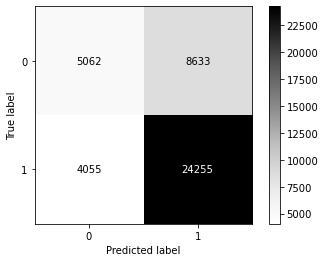

In [31]:
plot_confusion_matrix(xgb_rand_search, scaler_X_test, y_test,
                      cmap=plt.cm.Greys)
plt.show()

#### SMOTE 

In [32]:
smote = SMOTE()

##### Model Train

In [33]:
X_train_resampled, y_train_resampled = smote.fit_resample(scaler_X_train, y_train) 

In [34]:
xgb_rand_search.fit(X_train_resampled, y_train_resampled)

RandomizedSearchCV(estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                           colsample_bylevel=1,
                                           colsample_bynode=1,
                                           colsample_bytree=1,
                                           eval_metric='logloss', gamma=0,
                                           gpu_id=-1, importance_type='gain',
                                           interaction_constraints='',
                                           learning_rate=0.300000012,
                                           max_delta_step=0, max_depth=6,
                                           min_child_weight=1, missing=nan,
                                           monotone_constraints='()',
                                           n_estimators=100, n_jobs=4,
                                           num_parallel_tree=1, random_state=0,
                                           reg_alpha=0, reg_lambda=1

In [35]:
xgb_smote_pred_train = xgb_rand_search.predict(X_train_resampled)

In [36]:
print(classification_report(y_train_resampled, xgb_smote_pred_train, target_names=['On Time', 'Delay']))

              precision    recall  f1-score   support

     On Time       0.99      0.96      0.97     84542
       Delay       0.96      0.99      0.97     84542

    accuracy                           0.97    169084
   macro avg       0.97      0.97      0.97    169084
weighted avg       0.97      0.97      0.97    169084



In [37]:
print('Mean Absolute Error:', mean_absolute_error(y_train_resampled, xgb_smote_pred_train))
print('Mean Squared Error:', mean_squared_error(y_train_resampled, xgb_smote_pred_train))  
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_train_resampled, xgb_smote_pred_train)))

Mean Absolute Error: 0.0260698824253034
Mean Squared Error: 0.0260698824253034
Root Mean Squared Error: 0.16146170575496654


##### Model Test

In [38]:
X_test_resampled, y_test_resampled = smote.fit_resample(scaler_X_test, y_test) 

In [39]:
xgb_smote_pred_test = xgb_rand_search.predict(X_test_resampled)

In [40]:
print(classification_report(y_test_resampled, xgb_smote_pred_test, target_names=['On Time', 'Delay']))

              precision    recall  f1-score   support

     On Time       0.78      0.70      0.74     28310
       Delay       0.73      0.81      0.77     28310

    accuracy                           0.75     56620
   macro avg       0.76      0.75      0.75     56620
weighted avg       0.76      0.75      0.75     56620



In [41]:
print('Mean Absolute Error:', mean_absolute_error(y_test_resampled, xgb_smote_pred_test))
print('Mean Squared Error:', mean_squared_error(y_test_resampled, xgb_smote_pred_test))  
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test_resampled, xgb_smote_pred_test)))

Mean Absolute Error: 0.24747439067467325
Mean Squared Error: 0.24747439067467325
Root Mean Squared Error: 0.49746797954709937


##### Confusion Matrix

In [42]:
cnf_matrix = confusion_matrix(y_test_resampled, xgb_smote_pred_test)
cnf_matrix

array([[19793,  8517],
       [ 5495, 22815]], dtype=int64)

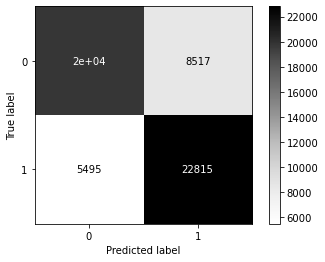

In [43]:
plot_confusion_matrix(xgb_rand_search, X_test_resampled, y_test_resampled,
                      cmap=plt.cm.Greys)
plt.show()